# Solutions to Problem Sheet 7 - Q3

In this problem, we want to use the finite difference method to solve the following diffusion problem
$$
\begin{aligned}
&\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad 0<x<1, t>0 \\
&u(0,t) = u(1,t) = 0 \\
&u(x,t) = 4x(1-x)
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

font = {'size'   : 14}
matplotlib.rc('font', **font)

First, we would like to determine the steady-state $U(x)$ of this problem. For that, we solve the time-independent equation 
$$
\frac{d^2 U}{d x^2} = 0 \Rightarrow U(x) = Ax+B
$$
with $A$ and $B$ integration constants to be determined. The steady-state solution needs to respect the boundary conditions which are given by $u(0,t) = u(1,t) = 0$.

Here, it imposes that $U(x) = 0$. 

Now, we want to implement a FTCS scheme to solve this problem over time. This problem involves Dirichlet boundary conditions. In the lecture notes, we have seen that the FTCS scheme in this case can be written in matrix form as 
$$
\mathbf{u}_{n+1} = A \mathbf{u}_n + \mathbf{b}_n 
$$
where $\mathbf{u}_n$ is a $(N-1)$-dimensional vector whose entries are the values of the solution for all grid points $i \in [1,N-1]$ at time step $n$. The matrix $A$ is a tridiagonal matrix defined as
$$
A = \begin{pmatrix}
1-2\alpha & \alpha & 0  & 0  & 0 \\
\alpha & 1-2\alpha & \alpha & 0  & 0 \\
0 & \alpha & 1-2\alpha  & \alpha  & 0 \\
0 & 0 &  \alpha & 1-2\alpha  & \alpha \\
0 & 0 &  0 & \alpha  & 1-2\alpha
\end{pmatrix}
$$
and 
$$
\mathbf{b}_n = \begin{pmatrix}
\alpha u_L(t_n)\\
0\\
0\\
0\\
\alpha u_R(t_n)
\end{pmatrix}
$$
where $\alpha = \Delta t/(\Delta x)^2$, and $u_L(t_n)$ and $u_R(t_n)$ are our Dirichlet boundary conditions evaluated at $t_n$.  

First, let us write a function which implements this FTCS scheme:

In [2]:
def diffusion_ftcs_dirichlet(par):
    # FTCS scheme with Dirichlet boundary conditons for the diffusion equation in 1D
    # This function takes as input: 
    # - par: a class containing the parameters of the simulation
    # It returns
    # - us: 2D array containing the solution surface
    # - xs: 1D array containing the location of the grid points
    # - ts: 1D array containing the value of the times at which the solution is available
    
    # Domain definition
    xmin = par.xmin
    xmax = par.xmax 
    T = par.T
    D = par.D

    # Boundary conditions (assume to be constant over time)
    ul = par.ul 
    ur = par.ur

    # Number of discretization points in space and time
    Nx = par.Nx
    Nt = par.Nt

    # Spatial and temporal step size
    dx = (xmax-xmin)/(par.Nx-1)
    dt = T/(par.Nt-1)

    # Check whether the stability criterion is met 
    if dt>dx**2/(2*D):
        raise Exception("Sorry, but stability condition is not met!")

    # Prepare the data structure
    ts = np.linspace(0,T,Nt)
    xs = np.linspace(xmin,xmax,Nx)
    us = np.zeros((len(xs),len(ts)))

    # Initialize the system with initial conditions
    us[:,0] = par.f(xs)
    up = us[1:Nx-1,0] # we are solving for interior points
    
    # Apply the boundary conditions
    us[0,:] = ul 
    us[-1,:] = ur 
    
    # Define the matrices
    a = D*dt/dx**2

    d1 = np.diag(      a*np.ones(Nx-3),-1)
    d2 = np.diag((1-2*a)*np.ones(Nx-2), 0)    
    d3 = np.diag(      a*np.ones(Nx-3),+1)
    A = d1 + d2 + d3

    b = np.zeros(Nx-2)
    b[0] = a*ul
    b[-1] = a*ur
    
    # For loop over time to advance the solution 
    for iT in range(1,Nt):
        un = np.matmul(A,up) + b
        us[1:-1,iT] = un
        up = un
        
    return xs,ts,us

Now that we have a function implementing the FTCS scheme, it is time to test it! We know that when using the FTCS method, we need to carefully choose our grid spacing and timesteps. Indeed, these should obey the following stability criterion 
$$
\Delta t \le \frac{(\Delta x)^2}{2D}
$$
Our implementation above checks whether this condition is met depending on your choice of discretization and throws an error if the stability criterion is not met!

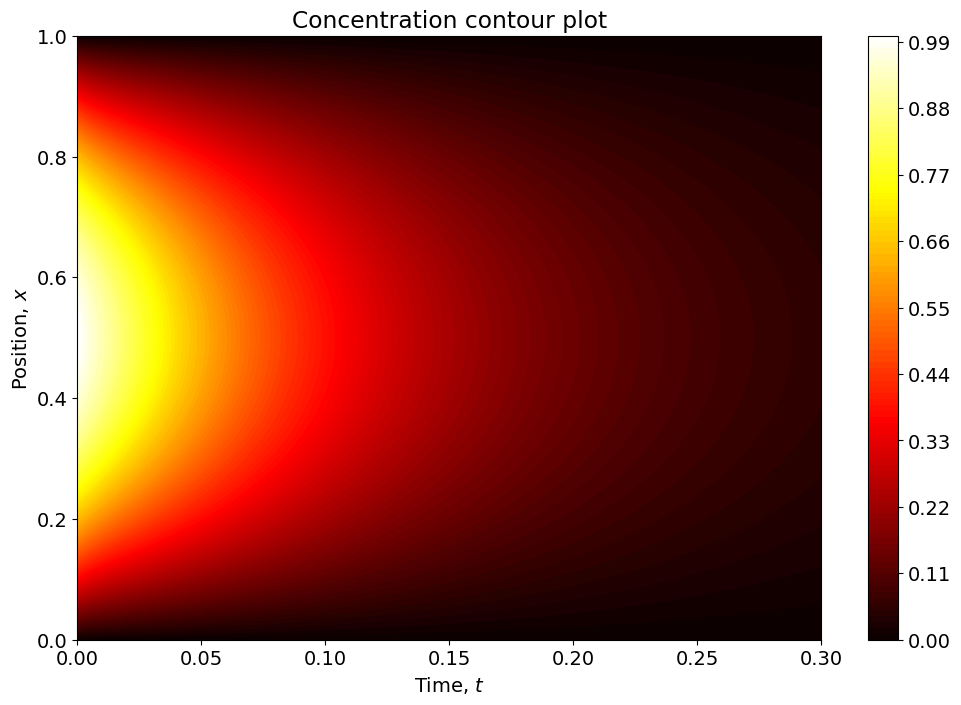

In [3]:
# Define the initial condition function
def ic(x):
    return 4*x*(1-x)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 1
par.T = 0.3
par.D = 1
par.ul = 0
par.ur = 0
par.Nx = 101
par.Nt = 10000
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_ftcs_dirichlet(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0, vmax=1)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()


We can see that our solution does converge to the steady state $U=0$ over time. Let's try now to reduce the number of time steps we are taking for a fixed total time (i.e. increase the size of our timesteps). 

In [4]:
# Define the initial condition function
def ic(x):
    return 4*x*(1-x)

# Create an empty class to contain our parameters
class params:
    pass

par = params()
par.xmin = 0
par.xmax = 1
par.T = 0.3
par.D = 1
par.ul = 0
par.ur = 0
par.Nx = 101
par.Nt = 1000
par.f = ic

# Solve the problem with finite differences 
xs,ts,us=diffusion_ftcs_dirichlet(par)

# Plot the solution
fig, ax = plt.subplots()
T, X = np.meshgrid(ts, xs)
c = plt.contourf(T, X, us, 100, cmap ="hot",vmin=0, vmax=1)
  
cbar = plt.colorbar(c)

ax.set_title('Concentration contour plot')
ax.set_ylabel(r'Position, $x$')
ax.set_xlabel(r'Time, $t$')

plt.show()


Exception: Sorry, but stability condition is not met!

Our code behaves as excepted and threw an exception at us! 